In [2]:
import pandas as pd
import pymysql
import numpy as np
import pyodbc
import matplotlib.pyplot as plt
import sys
import datetime

#Read for Clipboard
def GetClip():
    clip=pd.read_clipboard()
    cols=['ID','Name','BQty','SQty','Price','Trade','Status','Initiator','Ref','Time','OrderPrice','Order','Ext','Log']
    clip.columns=cols
    col1=['ID','Name','BQty','SQty','Price','Time','Log']
    return clip.loc[:,col1]

#Read data for SQL SERVER
def GetSQL():
    #conn=pyodbc.connect('DRIVER={SQL Server};SERVER=seo3;PORT=1433;DATABASE=stock;UID=sa;PWD=test1234')
    conn=pyodbc.connect('DRIVER={SQL Server};SERVER=SEO4\SQLEXPRESS;PORT=1433;DATABASE=stock;UID=sa;PWD=test1234')   
    sql="select ID,memo,date,case when type='BUY' then volume end BQty,case when type='SELL' then volume end  SQty,Price,Trade_Time,LNG from HK_Trade order by Trade_Time"
    df1=pd.read_sql(sql,conn)
    col1=['ID','Name','Date','BQty','SQty','Price','Time','Log']
    df1.columns=col1
    return df1

def GetMYSQL():
    #conn=pyodbc.connect('DRIVER={SQL Server};SERVER=seo3;PORT=1433;DATABASE=stock;UID=sa;PWD=test1234')
    conn=pymysql.connect("kairuiserver","kairuitouzi","kairuitouzi","stockdate" )    
    sql="select ID,memo,date,case when type='BUY' then volume end BQty,case when type='SELL' then volume end  SQty,Price,Trade_Time,LNG from HK_Trade order by Trade_Time"
    df1=pd.read_sql(sql,conn)
    col1=['ID','Name','Date','BQty','SQty','Price','Time','Log']
    df1.columns=col1
    return df1

# df=GetSQL()
#汇总成本
def CalcRec(line=0):   
    if line==0:
        SLists=df[df.SQty.notnull()]
        BLists=df[df.BQty.notnull()]
    else:
        df1=df.iloc[line:]
        SLists=df1[df1.SQty.notnull()]        
        BLists=df1[df1.BQty.notnull()]   
    Buy=BLists.loc[:,['BQty','Price',"Time"]]
    BB,Bsum=Buy.BQty.sum(),Buy.prod(1,1).sum()    
    Sell=SLists.loc[:,['SQty','Price','Time']]
    SS,Ssum=Sell.SQty.sum(),Sell.prod(1,1).sum()
    Result={}
    Result['Buy_Lots']=BB
    Result['Buy_Cost']=Bsum/BB
    Result['Sell_Lots']=SS
    Result['Sell_Cost']=Ssum/BB
    Result['Holds']=BB-SS
    Result['Charges']=max(BB,SS)*67.08
    if BB!=SS:        
        Result['Hold_Cost']=(Ssum-Bsum)/abs((BB-SS))
        Result['Hold_Cost1']=Result['Hold_Cost']+BB*67.08/50 if BB>SS else Result['Hold_Cost']-SS*67.08/50
    else:
        Result['Profit']=(Ssum-Bsum)*50.0
        Result['Net Profit']=Result['Profit']-Result['Charges']
    return Result         

def CloseSell(ii):
    CurL=df.iloc[ii]
    QTY=CurL.BQty
    while QTY>0:    
        if not len(b):
            CurL.at['BQty']=QTY
            a.append(CurL)              
            holdB=sum(l1.BQty for l1 in a)
            holdSum=sum(l1.BQty*l1.Price for l1 in a)
            OpenTime=CurL['Time']
            OpenPrice=CurL['Price']            
            ll=['addBuy',holdB,QTY,OpenTime,OpenPrice,0,holdSum/holdB]
            ResList.append(ll)
            #print(OpenTime,'add a')
            break 
        popSell=b.pop()       
        sq=popSell['SQty']        
        if sq<=QTY: 
            holdS=sum(l1.SQty for l1 in b)
            point=popSell.Price-CurL.Price
            profit=sq*point*50
            ll=['CloseS',-holdS,sq,popSell.Time,popSell.Price,CurL.Time,CurL.Price,point,profit]            
            QTY=QTY-sq
        elif sq>QTY:
            popSell.at['SQty']=sq-QTY
            b.append(popSell)
            holdS=sum(l1.SQty for l1 in b)
            point=popSell.Price-CurL.Price
            profit=QTY*point*50
            ll=['CloseS',-holdS,QTY,popSell.Time,popSell.Price,CurL.Time,CurL.Price,point,profit]           
            QTY=0
        ResList.append(ll)
            
def CloseBuy(ii):
    CurL=df.iloc[ii]
    QTY=CurL.SQty
    while QTY>0:
        if not len(a):
            CurL.at['SQty']=QTY
            a.append(CurL)              
            holdS=sum(l1.SQty for l1 in b)
            holdSum=sum(l1.SQty*l1.Price for l1 in b)
            OpenTime=CurL['Time']
            OpenPrice=CurL['Price']            
            ll=['addBuy',-holdS,QTY,OpenTime,OpenPrice,0,holdSum/holdS]
            ResList.append(ll)
            print(OpenTime,'add b')
            break
        popSell=a.pop()       
        bq=popSell['BQty']
        if bq<=QTY:
            holdB=sum(l1.BQty for l1 in a)
            point=CurL.Price-popSell.Price
            profit=bq*point*50
            ll=['CloseB',holdB,-bq,popSell.Time,popSell.Price,CurL.Time,CurL.Price,point,profit]           
            QTY=QTY-bq
        elif bq>QTY: 
            popSell.at['BQty']=bq-QTY
            a.append(popSell)
            holdB=sum(l1.BQty for l1 in a)
            point=CurL.Price-popSell.Price
            profit=QTY*point*50
            ll=['CloseB',holdB,-QTY,popSell.Time,popSell.Price,CurL.Time,CurL.Price,point,profit]           
            QTY=0
        ResList.append(ll)

# 每行计算
def CalcRows():
    index=0    
    global a
    global b
    global ResList
    a=[]
    b=[]
    ResList=[]
    for index in df.index:  
        CNTB,CNTS=len(a),len(b)
        #print(index,CNTB)
        if df.BQty[index]>0 and CNTS==0:            
            a.append(df.iloc[index])              
            holdB=sum(l1.BQty for l1 in a)
            holdSum=sum(l1.BQty*l1.Price for l1 in a)
            OpenTime=df.loc[index,'Time']
            OpenPrice=df.loc[index,'Price']            
            ll=['addBuy',holdB,df.BQty[index],OpenTime,OpenPrice,0,holdSum/holdB]
            ResList.append(ll)
        elif df.SQty[index]>0 and CNTB==0:
            b.append(df.iloc[index])  
            holdS=sum(l1.SQty for l1 in b)
            holdSum=sum(l1.SQty*l1.Price for l1 in b)
            OpenTime=df.loc[index,'Time']
            OpenPrice=df.loc[index,'Price']
            ll=['addSell',-holdS,-df.SQty[index],OpenTime,OpenPrice,0,holdSum/holdS]            
            ResList.append(ll)
        elif df.BQty[index]>0 and CNTS>0:           
            CloseSell(index)
        elif df.SQty[index]>0 and CNTB>0:        
            CloseBuy(index)        
            
    ResList=pd.DataFrame(ResList)
    cols=['Action','Hold','QTY','OpenTime','OpenPrice','CLoseTime','ClosePrice','Point','Profit']
    ResList.columns=cols    
    return ResList

# 汇总总的平仓情况
def CalcClose():
    rows=CalcRows()
    pp=rows[rows.Point.notnull()]
    show={}
    sumQTY=sum(abs(pp.loc[qq,'QTY'])for qq in pp.index)    
    sumProfit=pp.Profit.sum()
    sumPoint=pp.Point.sum()
    show['TotalProfit:']=sumProfit
    show['NetProfit:']=sumProfit-sumQTY*67.08
    show['Lots:']=sumQTY
    show['AvgPoint:']=sumPoint/sumQTY
    show['AvgProfit:']=sumProfit/sumQTY
    show['Chareges:']=sumQTY*67.08
    show['AvgNetP:']=sumPoint/sumQTY-67.08/50
    show['AvgNetPro:']=sumProfit/sumQTY-67.08
    return show

#汇总成本
def CalcRec(line=0):   
    if line==0:
        SLists=df[df.SQty.notnull()]
        BLists=df[df.BQty.notnull()]
    else:
        df1=df.iloc[line:]
        SLists=df1[df1.SQty.notnull()]        
        BLists=df1[df1.BQty.notnull()]   
    Buy=BLists.loc[:,['BQty','Price',"Time"]]
    BB,Bsum=Buy.BQty.sum(),Buy.prod(1,1).sum()    
    Sell=SLists.loc[:,['SQty','Price','Time']]
    SS,Ssum=Sell.SQty.sum(),Sell.prod(1,1).sum()
    Result={}
    Result['Buy_Lots']=BB
    Result['Buy_Cost']=Bsum/BB
    Result['Sell_Lots']=SS
    Result['Sell_Cost']=Ssum/BB
    Result['Holds']=BB-SS
    Result['Charges']=max(BB,SS)*67.08
    if BB!=SS:        
        Result['Hold_Cost']=(Ssum-Bsum)/abs((BB-SS))
        Result['Hold_Cost1']=Result['Hold_Cost']+BB*67.08/50 if BB>SS else Result['Hold_Cost']-SS*67.08/50
    else:
        Result['Profit']=(Ssum-Bsum)*50.0
        Result['Net Profit']=Result['Profit']-Result['Charges']
    return Result        

#Update Commission
def UpdateSql():
    print('Begin')
    conn=pyodbc.connect('DRIVER={SQL Server};SERVER=seo3;PORT=1433;DATABASE=stock;UID=sa;PWD=test1234')
    nd1=df[df.Date>'2017/9/7']
    for name,group in nd1.groupby([nd1.Date]):
        dd=group
        lots=dd.BQty.sum()-dd.SQty.sum()
        if lots!=0:
            dd1=dd[dd.SQty>0] if lots<0 else dd[dd.BQty>0]
            dd1.sort_index(by='Time',ascending=False)
            pos=0
            vv=abs(lots)
            while vv>0:
                sq=dd1.SQty.iloc[pos] if lots<0 else dd1.BQty.iloc[pos]
                sql="update hk_trade set AllCharges=Commission+Other1+Other2+%d*25.0 where lng=%d"
                if sq>vv:                
                    sql=sql %(vv,dd1.Log.iloc[pos])                
                    vv=0
                else:
                    sql=sql %(sq,dd1.Log.iloc[pos])                 
                    vv=vv-sq
                #print(sql)
                conn.execute(sql)
                pos=pos+1
    conn.commit()
    conn.close()
    print ('End')


print('Finished1')

Finished1


In [3]:
dt=datetime.datetime.now()
print('Begin')
#df=GetSQL()
df=GetMYSQL()
#df=GetClip()
list1=CalcRows()
print('End',datetime.datetime.now()-dt)
#show2=CalcClose()
#show2

Begin
End 0:00:15.382880


In [10]:
show1=CalcRec()
show1

{'Buy_Cost': 29051.85714285714,
 'Buy_Lots': 42.0,
 'Charges': 2817.36,
 'Holds': 0.0,
 'Net Profit': 37882.64,
 'Profit': 40700.0,
 'Sell_Cost': 29071.238095238095,
 'Sell_Lots': 42.0}

In [109]:
df=GetClip()
show1=CalcRec()
show1

{'Buy_Cost': 29051.85714285714,
 'Buy_Lots': 42.0,
 'Charges': 2817.36,
 'Holds': 0.0,
 'Net Profit': 37882.64,
 'Profit': 40700.0,
 'Sell_Cost': 29071.238095238095,
 'Sell_Lots': 42.0}

Populating the interactive namespace from numpy and matplotlib


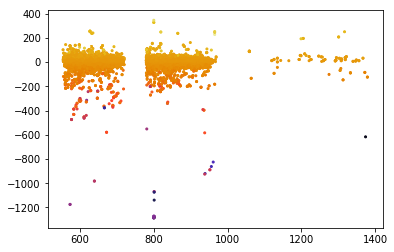

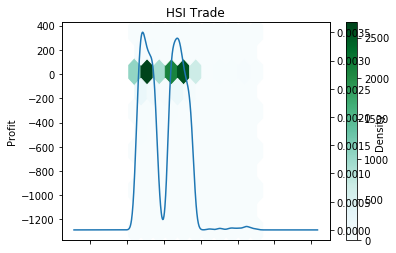

In [5]:
# 分析图测试 
%pylab inline
ss=ResList[ResList.Point!=0]
ss=ss.iloc[:20000]
ss['hh']=ss.loc[:,'OpenTime'].apply(lambda x:pd.to_datetime(x).hour*60+pd.to_datetime(x).minute)
plt.scatter(ss.hh,ss.Point,s=4,c=ss.Profit,cmap=plt.cm.CMRmap)
ss.plot.hexbin(x='hh', y='Point', gridsize=10)
a=[i*30 for i in range(9*2,16*2,1)]
b=[str(i//2)+":"+str(i%2*30) for i in range(9*2,16*2,1)]
plt.title('HSI Trade')
plt.xlabel('Trade Time')
plt.ylabel('Profit')
#plt.xticks(a,b)
plt.twinx()
ss.hh.plot(kind='kde')
plt.show()

In [6]:
#update Sec
Sec=0
ResList['Sec']=0
for i in ResList.index:
    if ResList.Hold.loc[i]==ResList.QTY.loc[i]:
        #print(i,Sec)
        Sec=Sec+1
    ResList.loc[i,'Sec']=Sec
    
ResList['CLoseTime']=ResList.CLoseTime.apply(lambda x:pd.to_datetime(0) if x==0 else x)

#按SEC汇总 
newSec=ResList.groupby('Sec').agg({'Hold':lambda x:min(x) if max(x)==0 else max(x),
                             'Profit':np.sum,'QTY':np.size,
                             'OpenTime':np.min,'CLoseTime':np.max,'Point':np.min})

newSec['MaxPoint']=ResList.groupby('Sec').agg({'Point':np.max})
newSec['Diff']=newSec.CLoseTime-newSec.OpenTime
newSec['Delta']=newSec.Diff.apply(lambda x:x.seconds+x.days*24*60*60)

newSec.rename(columns={'Point':'MinPoint','QTY':'CNT'},inplace = True)


print('OK')

OK


In [10]:
%pylab
tt=newSec.groupby('Hold')
newTT=tt.agg({'Profit':np.sum,'Hold':np.size})
newTT.sort_values(by='Profit',ascending=False)
#newTT.to_clipboard()

newTT['HH']=newTT.index
fig = plt.figure()
#newTT.plot.scatter(x='HH',y='CNT')
ax=newTT['Hold'].plot(kind='bar', color=['r','y'],use_index=True,grid=True,stacked=True,
                     label='Count',alpha=0.5)
ax.legend(loc='upper left') 
ax.set_ylabel("Count")


ax3=ax.twinx()
ax3.set_ylabel("Profit")
ax3=newTT['Profit'].plot(kind='bar', color='y',use_index=True,stacked=True,grid=True,label='Profit')
ax3.legend(loc = 0)  
plt.show()

# newTT.plot(kind='bar',subplots=True, figsize=(200, 200),layout=(3, 1),use_index=True,grid=True,sharex=False);


#newTT['HH']=abs(newTT.index)
#pp=newTT.groupby('HH').sum()
#pp['Cumsum']=pp.Profit.cumsum()
#b=[i for i in range(0,150,2)]
#plt.xticks(b)
#pp.Cumsum.plot(kind='area', figsize=(200, 200),use_index=True,grid=True,sharex=False);

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [47]:
test1=newSec[abs(newSec.Hold)>12]
hh=test1.Hold.apply(lambda x:abs(x)).sum()
pp=test1.Profit.sum()
pp/hh/50

-11.601309441764302

In [48]:
test2=test1[test1.Profit<0]
hh1=test1.Hold.apply(lambda x:abs(x)).sum()
pp1=test1.Profit.sum()
pp

-5050050.0

In [44]:
test2=test1[test1.Profit>0]
hh=test2.Hold.apply(lambda x:abs(x)).sum()
pp=test2.Profit.sum()
pp/hh/50

17.5600756859035

In [8]:
t1=datetime.datetime.now()
newSec['Delta']=newSec.Diff.apply(lambda x:x.seconds+x.days*24*60*60)
newSec['ctime']=0
for i in newSec.index:
    if newSec.Delta[i]<=5*60:
        ctime=1
    elif newSec.Delta[i]<=10*60:
        ctime=2
    elif newSec.Delta[i]<=20*60:
        ctime=3
    elif newSec.Delta[i]<=30*60:
        ctime=4
    elif newSec.Delta[i]<=60*60:
        ctime=5
    elif newSec.Delta[i]<=120*60:
        ctime=6
    elif newSec.Delta[i]<=180*60:
        ctime=7
    elif newSec.Delta[i]<=240*60:
        ctime=8
    elif newSec.Delta[i]<=480*60:
        ctime=9
    else:
        ctime=10
    newSec.ctime[i]=ctime

print("OK",datetime.datetime.now()-t1)
        

d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


OK 0:03:12.626017


In [9]:
%pylab
cc1=newSec.groupby('ctime').sum()
plt.tick_params(axis=10,colors='blue')
ax=cc1.Profit.plot(kind='bar',color='r',grid=True)
ax[2].tick_params(axis=10,colors='blue')
plt.show()
#plt.twinx()
#cc1.Profit.cumsum().plot(kind='line')

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


TypeError: 'AxesSubplot' object does not support indexing